In [1]:
%run stdPackages.ipynb
os.chdir(d['py'])
import US_EulerModel_main, US_EulerModel_c, US_EulerModel_policy
os.chdir(d['curr'])

## US FH:

Define data and parameters:

In [2]:
dates_log = pd.Index([1950, 1980, 2010, 2040, 2070, 2100], name = 't')
ν_log = np.array([1.504840069, 1.394563144, 1.178137696, 1.055068673, 1.018706685, 1.018706685])
T_log = len(ν_log)
T = T_log+5
dates = dates_log.union(pd.Index([dates_log[-1]+30*i for i in range(1,T-T_log+1)]))
ν = np.hstack([ν_log, np.full(T-T_log, ν_log[-1])])
A = np.ones(T) # normalize exog. productivity at 1 
t0date = 2010 # calibration date
t0 = dates.get_loc(t0date) # index for year of calibration 


# "Simple" calibration:
α = .281 # capital income share

# Household types:
γi  = np.array([.056, 0.449, 0.307, 0.188])
ni = len(γi)
hours = np.array([1415.38, 2114.79, 2315.83, 2458.91]) # hours
wagerates = np.array([6.914, 14.88, 27.32, 62.26]) # wages
income = hours*wagerates
zxi = hours/hours.mean()
zηi = income/income.mean()
pi = np.array([0.385, 0.55, 0.652, 0.74])
μi = np.array([0.362, 0.526, 0.684, 0.756]) # voter turnout 


# other targets:
τ0 = .158 # target labor tax rate
RR = 39.4/50.1 # replacement rate
universalShare = 3.4/15.8 # share of ss going to universal
R0 = 2.443 


# Initial/baseline values:
ξ0 = .5
ρ0 = 2
ω0 = 1.5
# βj = np.ones(ni+1)

Package them in kwargs:

In [3]:
kwargs = {'α': α, 'A': A, 'ν': ν, 'γi': γi, 'zxi': zxi, 'zηi': zηi, 'pi': pi, 'μi': μi, 'τ0': τ0, 'RR0': RR, 'UShare0': universalShare, 'R0': R0, 'ξ': ξ0, 'ρ': ρ0, 'ω': ω0}

Initialize model:

In [4]:
m = US_EulerModel_main.Model(ni = ni, T = T, ngrid = 50, **kwargs)

Update grid settings:

In [5]:
grids = m.ESC.grids.copy() | {'n': {'τ': 101, 'κ': 11}}
m.ESC.kwargs_t = {'style': 'VeryRobust'} | grids
m.ESC.kwargs_T = {'style': 'VeryRobust'} | grids

Notes:
* It looks like there are different levels of $\beta, \omega$ that leads to the same calibration of the model. This is important for the outcome of $\kappa$ under the calibration.
* It can be a bit tricky to calibrate the model for different levels of $\rho, \xi$. It seems that the better approach is to start with high combinations of $\rho, \xi$ and gradually lower them.

In [6]:
ρ0 = m.db['ρ']
ξ0 = m.db['ξ']
ω0 = m.db['ω']
β0 = m.db['βi']
ρgrid = np.round(np.linspace(ρ0, 1.1, 10), 1)
ξgrid = np.round(np.linspace(ξ0, .1, 21), 3)

Store some of the initial values manually, so we can use them later:

In [7]:
initial_ω = {(2, .5): 1.534869, (1.9, .5): 1.577026461250184, (1.8, 0.5): 1.602444773589827}
initial_β = {(2, .5): np.full(ni, .41372489), (1.9, .5): np.full(ni, 0.42435811), (1.8, .5): np.full(ni, 0.43713564)}

Empty structures to store solution:

In [8]:
sols = dict.fromkeys(pd.MultiIndex.from_product([ρgrid, ξgrid]))
pols = sols.copy()
ωs, βs = sols.copy(), sols.copy()

*Test:*

In [9]:
# ρ = ρgrid[2]
# ξ = ξgrid[0]
# m.db['ω'], m.db['βi'] = initial_ω[(ρ, ξgrid[0])], initial_β[(ρ,ξgrid[0])].copy()
# soli, poli = m.ESC_FH(returnPols = True)

Loop through $\rho, \xi$:

In [10]:
for i in range(len(ρgrid)):
    ρ = ρgrid[i]
    m.db['ρ'] = ρ
    if i == 0:
        m.db['ω'], m.db['βi'] = initial_ω[(ρ, ξgrid[0])], initial_β[(ρ,ξgrid[0])].copy() # use initial values that we have stored
    else:
        m.db['ω'], m.db['βi'] = ωs[(ρgrid[i-1], ξgrid[0])], βs[(ρgrid[i-1], ξgrid[0])] # use previous iteration's solution
    for ξ in ξgrid:
        m.db['ξ'] = ξ
        print(f"ξ = {ξ}")
        try:
            m.USCalSimple_ESC_FH(t0);
            sols[(ρ, ξ)], pols[(ρ,ξ)] = m.ESC_FH(returnPols = True)
            ωs[(ρ,ξ)], βs[(ρ,ξ)] = m.db['ω'].copy(), m.db['βi'].copy()
            print(f'Solved')
        except Exception as e:
            print(e)

ξ = 0.5
Solved
ξ = 0.48
Solved
ξ = 0.46
Solved
ξ = 0.44
Solved
ξ = 0.42
Solved
ξ = 0.4
Solved
ξ = 0.38
Solved
ξ = 0.36
Solved
ξ = 0.34
Solved
ξ = 0.32
Solved
ξ = 0.3
Solved
ξ = 0.28
Solved
ξ = 0.26
Solved
ξ = 0.24
Solved
ξ = 0.22
Solved
ξ = 0.2
Solved
ξ = 0.18
Solved
ξ = 0.16
Solved
ξ = 0.14
Solved
ξ = 0.12
Solved
ξ = 0.1
Solved
ξ = 0.5
Solved
ξ = 0.48
Solved
ξ = 0.46
Solved
ξ = 0.44
Solved
ξ = 0.42
Solved
ξ = 0.4
Solved
ξ = 0.38
Solved
ξ = 0.36
Solved
ξ = 0.34
Solved
ξ = 0.32
Solved
ξ = 0.3
Solved
ξ = 0.28
Solved
ξ = 0.26
Solved
ξ = 0.24
Solved
ξ = 0.22
Solved
ξ = 0.2
Solved
ξ = 0.18
Solved
ξ = 0.16
Solved
ξ = 0.14
Solved
ξ = 0.12
Solved
ξ = 0.1
Solved
ξ = 0.5
Solved
ξ = 0.48
Solved
ξ = 0.46
Solved
ξ = 0.44
Solved
ξ = 0.42
Solved
ξ = 0.4
Solved
ξ = 0.38
Solved
ξ = 0.36
Solved
ξ = 0.34
Solved
ξ = 0.32
Solved
ξ = 0.3
Solved
ξ = 0.28
Solved
ξ = 0.26
Solved
ξ = 0.24
Solved
ξ = 0.22
Solved
ξ = 0.2
Solved
ξ = 0.18
Solved
ξ = 0.16
Solved
ξ = 0.14
Solved
ξ = 0.12
Solved
ξ = 0.1
Solved
ξ = 0.5

Something similar for the lower bound:

In [11]:
ρgrid_l = np.round(np.linspace(.9, .5, 5), 1)
sols_l = dict.fromkeys(pd.MultiIndex.from_product([ρgrid_l, ξgrid]))
pols_l = sols_l.copy()
ωs_l, βs_l = sols_l.copy(), sols_l.copy()

In [12]:
initial_ω[(ρgrid_l[0], ξgrid[0])] = ωs[(ρgrid[-1], ξgrid[0])]
initial_β[(ρgrid_l[0], ξgrid[0])] = βs[(ρgrid[-1], ξgrid[0])]

Loop through $\rho, \xi$:

In [13]:
for i in range(len(ρgrid_l)):
    ρ = ρgrid_l[i]
    m.db['ρ'] = ρ
    if i == 0:
        m.db['ω'], m.db['βi'] = initial_ω[(ρ, ξgrid[0])], initial_β[(ρ,ξgrid[0])].copy() # use initial values that we have stored
    else:
        m.db['ω'], m.db['βi'] = ωs[(ρgrid_l[i-1], ξgrid[0])], βs[(ρgrid_l[i-1], ξgrid[0])] # use previous iteration's solution
    for ξ in ξgrid:
        m.db['ξ'] = ξ
        print(f"ξ = {ξ}")
        try:
            m.USCalSimple_ESC_FH(t0);
            sols_l[(ρ, ξ)], pols_l[(ρ,ξ)] = m.ESC_FH(returnPols = True)
            ωs[(ρ,ξ)], βs[(ρ,ξ)] = m.db['ω'].copy(), m.db['βi'].copy()
            print(f'Solved')
        except Exception as e:
            print(e)

ξ = 0.5
Solved
ξ = 0.48
Solved
ξ = 0.46
Solved
ξ = 0.44
Solved
ξ = 0.42
Solved
ξ = 0.4
Solved
ξ = 0.38
Solved
ξ = 0.36
Solved
ξ = 0.34
Solved
ξ = 0.32
Solved
ξ = 0.3
Solved
ξ = 0.28
Solved
ξ = 0.26
Solved
ξ = 0.24
Solved
ξ = 0.22
Solved
ξ = 0.2
Solved
ξ = 0.18
Solved
ξ = 0.16
Solved
ξ = 0.14
Solved
ξ = 0.12
Solved
ξ = 0.1
Solved
ξ = 0.5
Solved
ξ = 0.48
Solved
ξ = 0.46
Solved
ξ = 0.44
Solved
ξ = 0.42
Solved
ξ = 0.4
Solved
ξ = 0.38
Solved
ξ = 0.36
Solved
ξ = 0.34
Solved
ξ = 0.32
Solved
ξ = 0.3
Solved
ξ = 0.28
Solved
ξ = 0.26
Solved
ξ = 0.24
Solved
ξ = 0.22
Solved
ξ = 0.2
Solved
ξ = 0.18
Solved
ξ = 0.16
Solved
ξ = 0.14
Solved
ξ = 0.12
Solved
ξ = 0.1
Solved
ξ = 0.5
Solved
ξ = 0.48
Solved
ξ = 0.46
Solved
ξ = 0.44
Solved
ξ = 0.42
Solved
ξ = 0.4
Solved
ξ = 0.38
Solved
ξ = 0.36
Solved
ξ = 0.34
Solved
ξ = 0.32
Solved
ξ = 0.3
Solved
ξ = 0.28
Solved
ξ = 0.26
Solved
ξ = 0.24
Solved
ξ = 0.22
Solved
ξ = 0.2
Solved
ξ = 0.18
Solved
ξ = 0.16
Solved
ξ = 0.14
Solved
ξ = 0.12
Solved
ξ = 0.1
Solved
ξ = 0.5

In [14]:
x = {k:v for k,v in sols_l.items() if v is None}

NOTE: 
* For $\rho=1.1$ we could get pretty close to the true solution. There is however, some tricky part with the calibration:
    * It seems like large values of both $\omega, \beta$ can give a corner solution for $\kappa$ *and* the calibration targets.
    * A second calibrated equilibrium are more moderate values of the two and instead an interior solution for $\kappa$.
    * IT LOOKS LIKE FOR $\kappa=0$ THERE ARE DIFFERENT SCALES OF $\omega,\beta$ THAT SOLVE THE MODEL.
* If we start the model from $\xi=.3$ and then gradually lower it (e.g. 0.25, 0.225, then 0.21515) we get the interior solution around $\xi = .21515$
* NOTE: This is pretty close to the log-case. Let us try to go back and investigate that shit again :O

Drop unsolved states:

In [15]:
[sols.pop(k) for k in list(sols.keys()).copy() if sols[k] is None];    
[pols.pop(k) for k in list(pols.keys()).copy() if pols[k] is None];

Plot $\kappa$ in target year as a function of parameters:

In [16]:
κ = pd.Series([sols[k]['κ'].xs(t0) for k in sols], index = pd.MultiIndex.from_tuples(sols.keys(), names = ['ρ','ξ']))

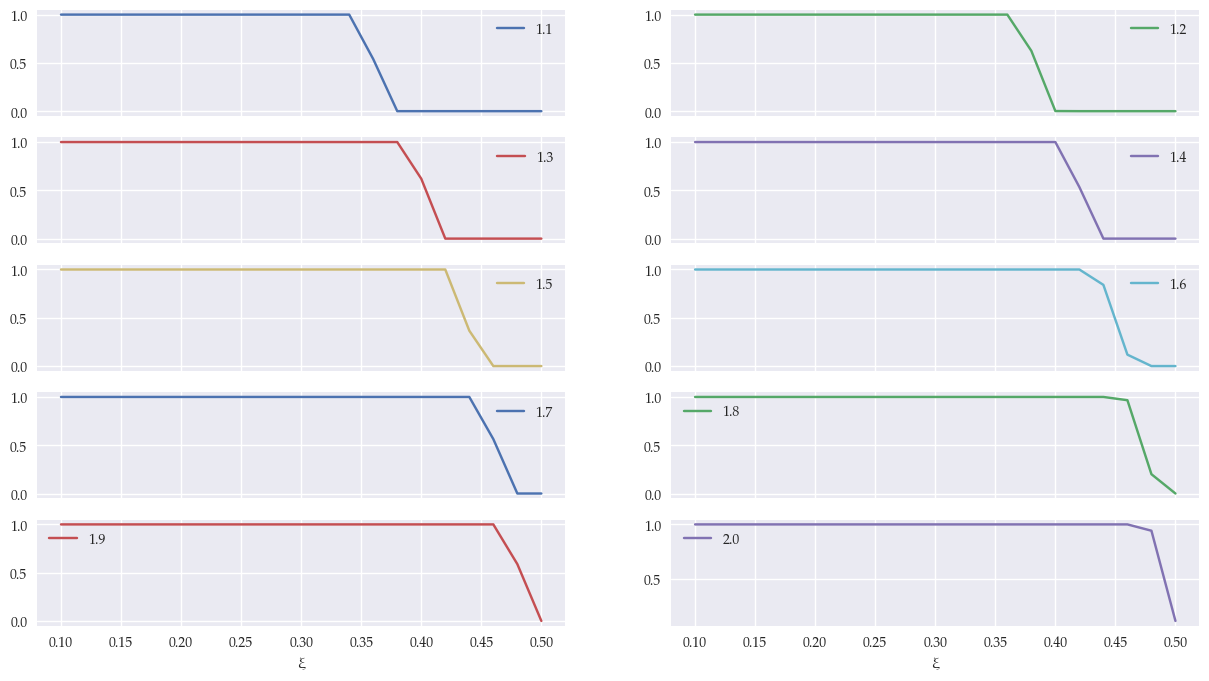

In [17]:
κ.unstack('ρ').plot(subplots = True, layout = (5,2), figsize = (15,8));

For the lower level part:

Drop unsolved states:

In [18]:
[sols_l.pop(k) for k in list(sols_l.keys()).copy() if sols_l[k] is None];    
[pols_l.pop(k) for k in list(pols_l.keys()).copy() if pols_l[k] is None];

Plot $\kappa$ in target year as a function of parameters:

In [19]:
κ = pd.Series([sols_l[k]['κ'].xs(t0) for k in sols_l], index = pd.MultiIndex.from_tuples(sols_l.keys(), names = ['ρ','ξ']))

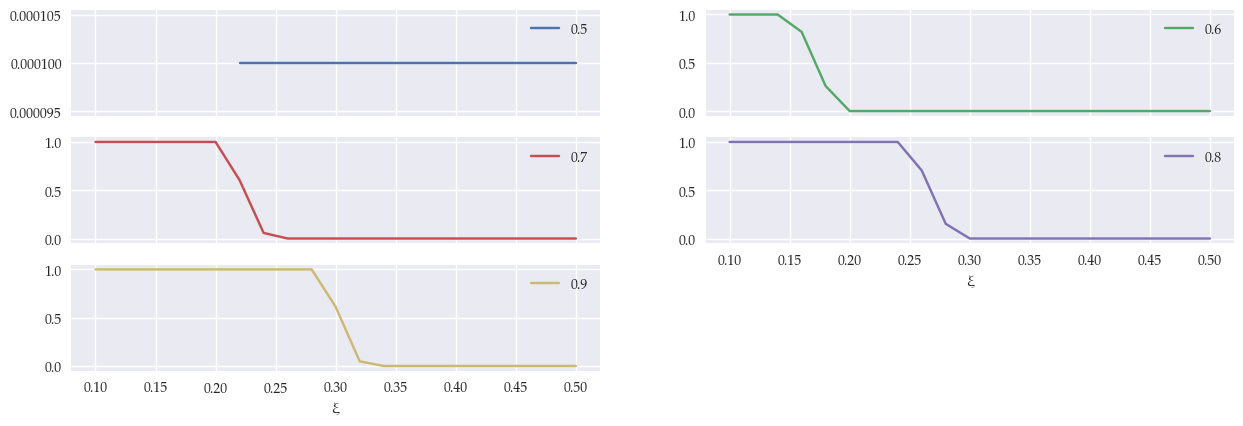

In [20]:
κ.unstack('ρ').plot(subplots = True, layout = (5,2), figsize = (15,8));

Store elements:

In [21]:
import pyDbs, pickle
dbStore = pyDbs.SimpleDB()
dbStore['ω'] = ωs
dbStore['βi'] = βs
dbStore['sol'] = sols | sols_l
dbStore['pol'] = pols | pols_l
with open(os.path.join(os.getcwd(), 'US_gridsearch'), "wb") as file:
    pickle.dump(dbStore, file)